In [4]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [5]:
path = 'AB_Test_Results.csv'
df = pd.read_csv(path)

Сделаем первоначальный анализ данных:

In [6]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [7]:
df.nunique()

,0
USER_ID,6324
VARIANT_NAME,2
REVENUE,101


In [8]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Давайте посмотрим, есть ли пользователи, которые состоят и в группе 'control' и в 'varinat' одновременно

In [9]:
#распределение кол-ва уникальных групп для каждого пользователя
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

,count
VARIANT_NAME,
1,4783
2,1541


In [10]:
#посмотрим на распределение по долям
double_variant_count / double_variant_count.sum()

,count
VARIANT_NAME,
1,0.756325
2,0.243675


Мы видим, что такие пользователи есть и их довольно много - 24%. Если учитывать этих пользователей, то эффект изменений в эксперименте будет размыт. Поэтому мы исключаем данные пользователей из расчета изменений в эксперименте.

In [11]:
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]
df = df[df['USER_ID'].isin(single_variant_users.index)]


In [12]:

# на всякий случай проверим, что количество пользователей совпадает с тем, что было до исключения
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

Давайте посмотрим, как распределены данные.

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

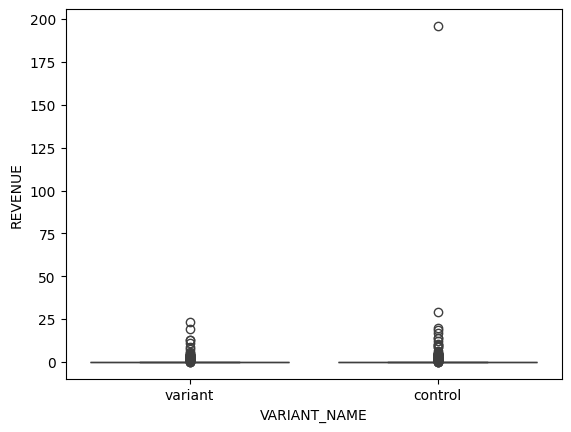

In [13]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

Видно, что в данных есть сильный выброс — найдем его, отсортировав эти значения выручки в порядке убывания.

In [14]:
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


Посмотрим, были ли у пользователя 3342 другие события с сильным выбросом.

In [15]:
df[df['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


Мы видим, что есть только один выброс - в условиях ограниченной информации мы удалим эту запись и посмотрим на распределение данных еще раз.

In [16]:
df = df[df['USER_ID'] != 3342]

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

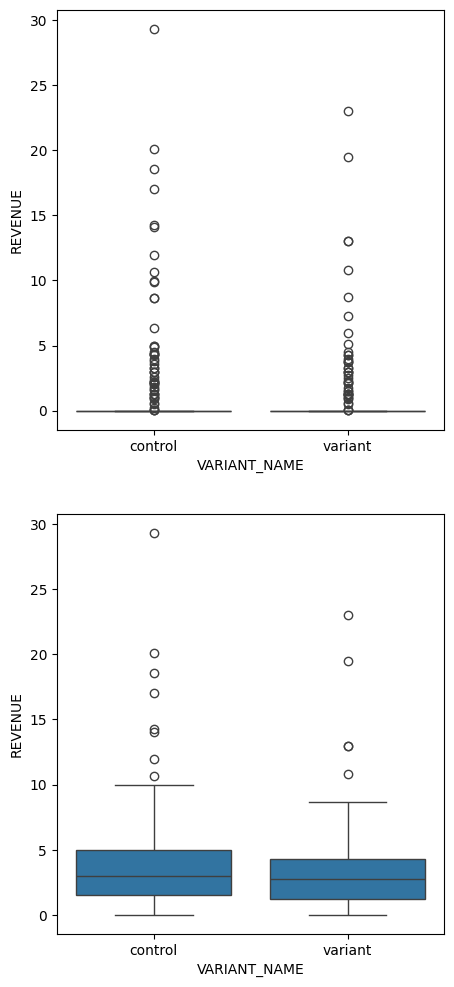

In [17]:
f, axes = plt.subplots(2, sharex=False, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df, order = ["control","variant"])
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0], order = ["control","variant"])

Видим, что у большинства пользователей нет покупок. Давайте разберемся, что это за пустые покупки: либо это информация по всем пользователям, независимо от их действий (даже при отсутствии посещений и положительных покупок), либо эти записи проставляются в случае входа без покупок и могут быть и другие записи с положительным доходом.

In [18]:
# давайте посмотрим, есть ли пользователи, у которых есть записи с нулевым и положительным доходом
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)),
    'USER_ID'
]).count()

52

У одного и того же пользователя действительно могут быть записи как с нулевым, так и с положительным доходом.

Давайте предположим, что записи — это посещения сервиса пользователями, а экспериментальная единица — пользователи. Затем мы группируем данные по каждому пользователю и суммируем доход для каждого, чтобы получить одну запись на пользователя

In [19]:
df_old = df.copy()

df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

Посмотрим на распределение, которое у нас получилось и сравним с прошлым распределением

Text(0.5, 1.0, 'Новые данные без нулей')

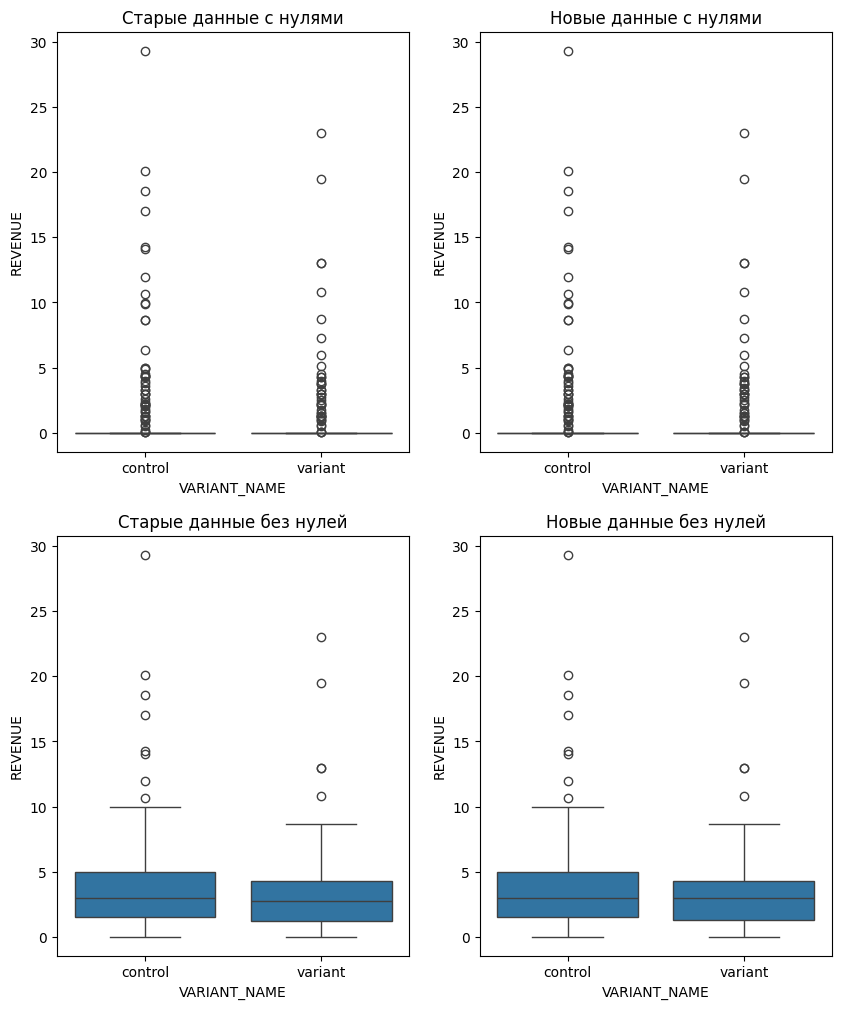

In [20]:
f, axes = plt.subplots(2, 2, sharex=False, figsize=(10,12))
sns.boxplot(ax = axes[0,0], x = 'VARIANT_NAME', y = 'REVENUE', data = df_old, order = ["control","variant"])
axes[0,0].set_title('Старые данные с нулями')
sns.boxplot(ax = axes[1,0], x = 'VARIANT_NAME', y = 'REVENUE', data = df_old[df_old['REVENUE'] > 0], order = ["control","variant"])
axes[1,0].set_title('Старые данные без нулей')
sns.boxplot(ax = axes[0,1], x = 'VARIANT_NAME', y = 'REVENUE', data = df, order = ["control","variant"])
axes[0,1].set_title('Новые данные с нулями')
sns.boxplot(ax = axes[1,1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0], order = ["control","variant"])
axes[1,1].set_title('Новые данные без нулей')

Исходя их графиков можем сказать, что распределение и в тестовой, и в конторольной выборках практически не изменилось. Также видим, что почти все квантилив тестовой выборке ниже чем в конторольной

Далее рассмотрим некоторые метрики, которые потребуются нам для A/B теста



In [21]:
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})


orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

Мы видим, что в тестовой группе общая сумма выручки и средний чек на пользователя снизились, но количество заказов на пользователя немного выросло.

Давайте также посмотрим, как ведут себя платящие пользователи

In [22]:
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

Давайте посмотрим на распределение всех и только платящих пользователей.

<ipython-input-23-4846aa293f86>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
<ipython-input-23-4846aa293f86>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'],

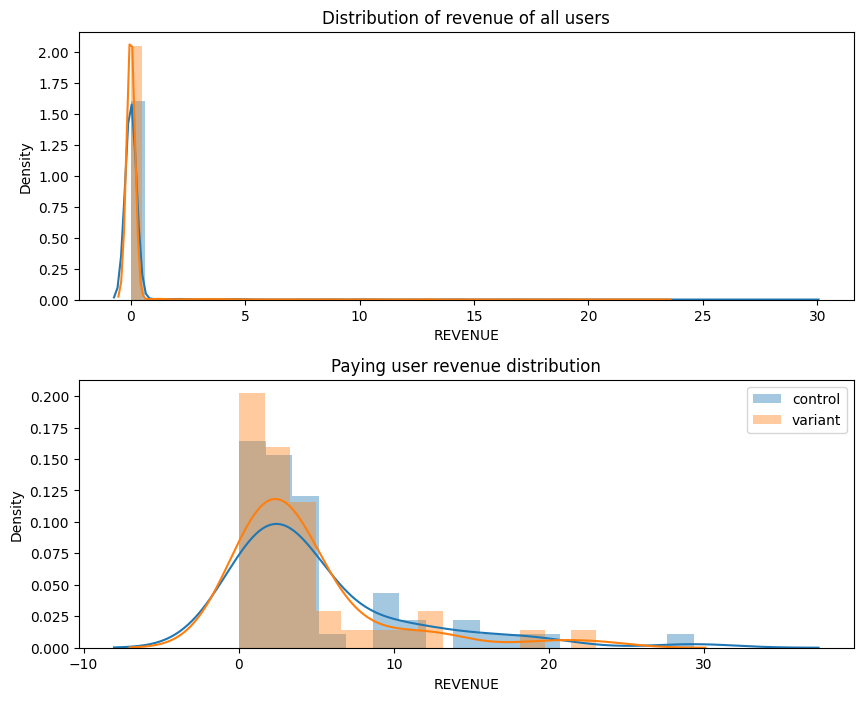

In [23]:
f, axes = plt.subplots(2, figsize=(10,8))
# построим график распределения всех клиентов
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# построим график распределения платящих клиентов
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Статистический анализ <a name="Statistical"/>

####**Постановка**

Сформулируем нулевую и альтернативную гипотизы

H0: среднее в контрольной выборке < среднее в тестовой выборке
H1: среднее в контрольной выборке < среднее в тестовой выборке

#### Проверка на нормальность распределения

На основе их предыдущего графика мы видим, что данные не распределены нормально, но на всякий случай мы можем подтвердить это формально, используя критерий Шапиро-Уилка.

In [ ]:
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)

Нулевая гипотеза о нормальном распределении данных отвергается.

Также выборка не слишком большая, поэтому Z-тест и T-тест.
Про верим гипотизы при помощи бутсрепа.

#### Bootstrap

Чтобы получить более полную информацию о различиях между средними значениями групп ab-теста, мы будем использовать bootstap.

Давайте создадим функцию для получения выборок и получения доверительного интервала

In [27]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Сгенерируем образцы для всех пользователей

In [28]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

И только для платящих пользователей

In [29]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Посмотрим на распределение средних значений в группах ab-теста.

<ipython-input-30-bbd15cbe742c>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
<ipython-input-30-bbd15cbe742c>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Распределение выборочного среднего для всех пользователей')

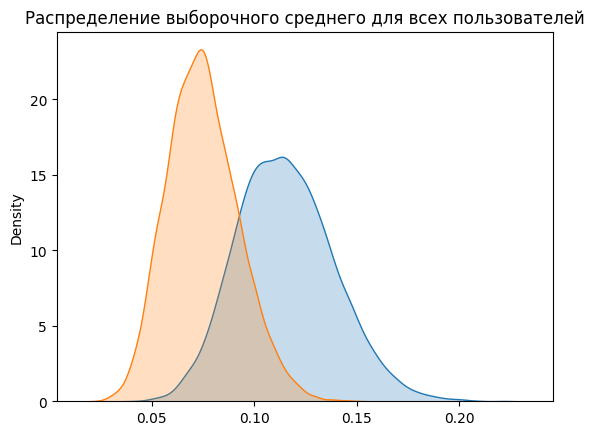

In [30]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Распределение выборочного среднего для всех пользователей')

<ipython-input-31-a42bf69da2c8>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
<ipython-input-31-a42bf69da2c8>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Распределение выборочного среднего для платящих пользователей')

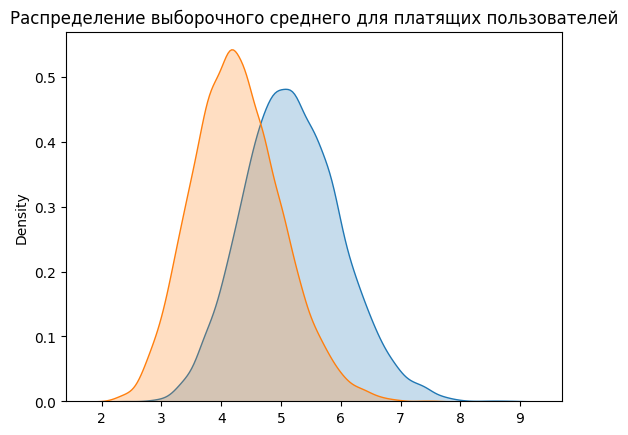

In [31]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Распределение выборочного среднего для платящих пользователей')

Мы видим, что различия есть, но доверительные интервалы могут перекрываться, поэтому нужно посмотреть на распределение разницы средних между группами, чтобы сделать окончательные выводы.

Давайте оценим разницу между группами: посмотрим на распределение разницы средних и построим для нее доверительные интервалы. Для этого создадим функцию для визуализацииn

In [47]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Построим график распределения средней разницы и вычислите доверительные интервалы. """
    f, ax = plt.subplots()
    # поличим данные для отрисовки доверительного интервала
    points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # выделим нулевое значение и границы доверительного интервала
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # покрасим зону доверительного интревала и вне его
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% доверительный интервал')
    plt.title(f'Распределение разности между средними в тестовой и контрольной выборках для {title}; {100*(1-alpha)}% Доверительный интервал для разности средних: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    return stat_intervals(variant - control)

<ipython-input-47-e4b72e77e43b>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()


array([-0.09884352,  0.01643135])

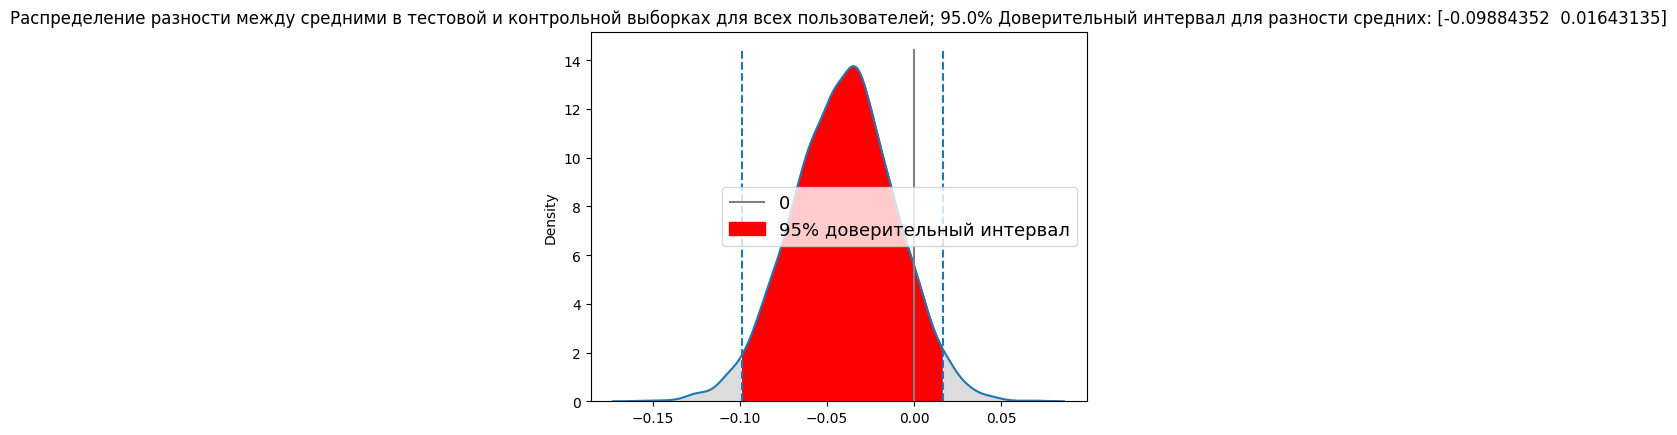

In [49]:
plot_distribution_and_stat_intervals(
    np.mean(variant, axis=1),
    np.mean(control, axis=1),
    title='всех пользователей'
)

Построим график распределения разницы средних значений и получим доверительный интервал для всех пользователей

<ipython-input-47-e4b72e77e43b>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=False).get_lines()[0].get_data()


array([-3.08132704,  1.22402201])

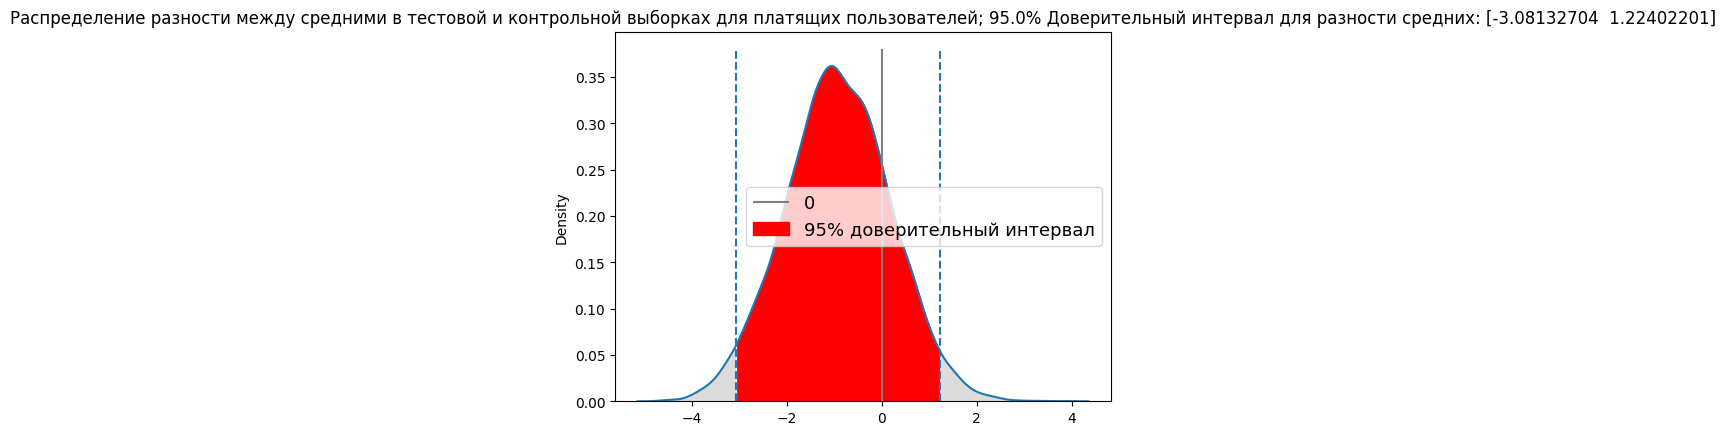

In [50]:
plot_distribution_and_stat_intervals(
    np.mean(variant_paid, axis=1),
    np.mean(control_paid, axis=1),
    title='платящих пользователей'
)

Мы видим, что нулевое значение находится в пределах доверительного интервала, поэтому мы не можем сказать о статистически значимом изменении среднего дохода между группами ab-теста.

### Заключение <a name="Conclusions"/>
Для того чтобы сделать выводы об изменениях между группами ab-теста, в данные были сначала внесены следующие изменения:

Пользователи с двумя группами ab-теста были исключены, чтобы сделать эффект изменений более выраженным User_id=3342 был исключен, так как в условиях ограниченной информации он является сильным выбросом в полученной выборке Пользователи взяты в качестве экспериментальной единицы, а затем данные сгруппированы по каждому пользователю и доходу и суммированы по каждому, чтобы получить одну запись на пользователя Несмотря на то, что доход в группе тестирования значительно снизился, статистически значимых изменений между группами ab-теста не произошло, как среди всех пользователей, так и среди только платящей аудитории.